# Gaussian Process Regression

GPR attempts to approximate a function $f(x)$ as a Gaussian of the form $\mathcal{N}(m(x), k(x,x'))$.

Mathematically, 
<body> <center>$ y = f(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(0,\sigma^2)$</center><body>
    
As stated above, we approximate $f(x) \sim GP(m(x), k(x,x'))$

Let us first consider a linear time series example:

A vehicle is moving at 2m/s in a particular direction. It's position is obtained through a noisy sensor ($\mathcal{N}(0,0.25)$). It is our task to determine a model that can fit the data obtained from the sensor. Assume the vehicle starts from rest.

In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Positon(m)')

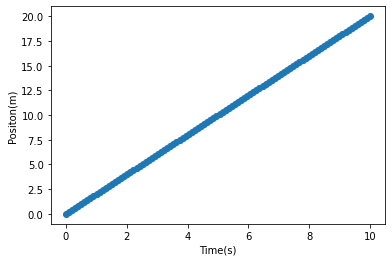

In [2]:
train_X = np.linspace(0,10,100)
train_Y = 2 * train_X
plt.scatter(train_X, train_Y)
plt.xlabel('Time(s)')
plt.ylabel('Positon(m)')

The above is a perfect (noise-free system). Now consider the same with noise (as described in the question).

Text(0, 0.5, 'Positon(m)')

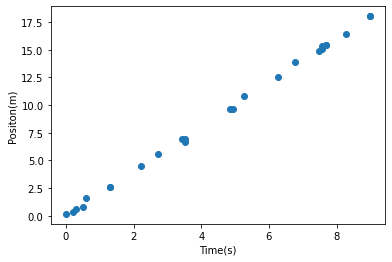

In [3]:
np.random.seed(12)
σ = np.sqrt(0.25)
train_x = torch.linspace(0,10,100)[np.random.randint(0,100,25)]
train_y = torch.Tensor(2 * train_x + torch.randn(train_x.size()) * σ**2)
plt.scatter(train_x, train_y)
plt.xlabel('Time(s)')
plt.ylabel('Positon(m)')

This is a noisy sensor reading. Now, from high school physics, we know that the above model is given by 

<body> <center> $\dfrac{dy}{dx} = v$ </center> </body>

or

<body> <center> $y = vx + \epsilon$ </center> </body>

where, $v$ is the velocity, $x$ is the time, $y$ is the position and $\epsilon$ is the noise as described in the question. We are given $v|_{x = 0} = 0$

But assume for a second that we do not know the underlying model. How do we pick a model that will satisfy the data observed? Given the sparse data that we have, we can't absolutely certain of a model (linear, quadratic, cubic, logarithmic, sum of sines and cosines, etc.). Instead of selecting a model and fitting it, we can perform GPR such that it takes into account all models.

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

Here, we have defined an Exact Gaussian Process model (Exact in the sense that the prior, likelihood, and the posterior are all Gaussian distributions).

We initialise the class using the ExactGP model predefined in GPyTorch. The initialisation involves declaring the training data (X,Y) and the likelihood distribution.

Further, when initialising, we initialise the mean and covariance of the GP model.

Next, we define the forward pass. The forward pass is used to predict when a new $x$ is provided. The forward pass returns the multivariate normal distribution with the proper mean and covariance based on the $x$.

In [5]:
for x in model.named_parameters():
    print(x)

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
('mean_module.constant', Parameter containing:
tensor([0.], requires_grad=True))
('covar_module.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True))
('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True))


1. ```raw_noise``` within ```likelihood``` corresponds to the $\sigma^2$ noise in the likelihood function ($\sim \mathcal{N}(0, \sigma^2)$)
2. ```constant``` within the ```mean_module``` corresponds to the mean of the model.
3. ```raw_outputscale``` within the ```covar_module``` corresponds to the scaling factor $\eta$ (described below).
4. ```raw_lengthscale``` within the ```covar_module``` corresponds to the lengthscale $l$ within the covariance module (described below)

<body> <center> $likelihood \sim \mathcal{N}(0,\sigma^2)$ </center> </body>
    
<body> <center> $\mu(x) = constant$ </center> </body>
    
<body> <center> $k(x,x') = \eta * exp\Big(-\dfrac{1}{2l^2} |x - x'|^2 \Big)$ </center> </body>


In [6]:
# Find optimal model hyperparameters
model.train()
likelihood.train()
training_iter = 500

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()

In [7]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [8]:
test_x = torch.linspace(0, 10 , 100)
f_pred = model(test_x)
y_pred = likelihood(model(test_x))

f_mean = f_pred.mean
f_var = f_pred.variance
f_covar = f_pred.covariance_matrix
f_samples = f_pred.sample(sample_shape=torch.Size([100]))

/Users/jaymehta/miniconda3/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", NumericalWarning)


In [9]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

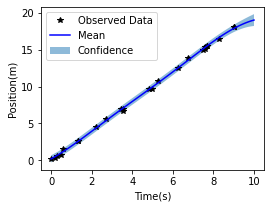

In [27]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
#     ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_xlabel('Time(s)')
    ax.set_ylabel('Position(m)')

Note here that the blue line is almost having the correct slop until the end of the data where there is a lack of data. The line is flattening as it starts to revert to the prior for $\mu$ which was a constant.